# Stock Price Indicator

## Project Overview

Student provides a high-level overview of the project. Background information such as the problem domain, the project origin, and related data sets or input data is provided.


Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.


Here, I build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates. Inputs contain multiple metrics:
 * opening price (Open)
 * highest price the stock traded at (High)
 * how many stocks were traded (Volume)
Whereas the prediction is made on:
 * closing price adjusted for stock splits and dividends (Adjusted Close)

We want to explore, where possible, S&P500 companies. The list of the listed companies is taken from [here](https://datahub.io/core/s-and-p-500-companies). 
The trading data comes from [Quandl End-of-Day US stock prices](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices) and it is downloaded through their [API](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices/usage/quickstart/api) and stored locally. Details are provided into the `Data Exploration` section below.

#### Project Format and Features
The project is developed in the form of a simple script.
<br/>EXTRA: (and any additions/modifications you want to make to the project (e.g. suggesting what trades to make))


## Problem Statement

The aim of the project is to predict stock's adjusted closing prices at 1, 7, 14 and 28 days, by giving stock data a time window of $n$ precedent days. The model should work for highly relevant companies, therefore a few from S&P500 are selected due to data availability.

Data is collected and wrangled to provide training and testing data in the format of features (open, min, max, close, split and dividend) and output vector (the adjusted closing price at the relative time shifts). Data is standardised and a experiments are conducted to test and improve performances.

## Metrics

I used Mean Squared Error to measure performance of the model during training. As a reminder, it is the mean of the squared difference between predicted and true values:

$MSE=\frac{1}{n} \Sigma(Y_i - \hat{Y_i})^2$

which is preferred to the mean absolute error due to its tendency to penalise more bigger errors. By doing so, The aim is to drive to model to avoid big errors rather than producing more equally distributed ones.

## Requirements

Requirements for the python environment can be found in `<repo_folder>/requirements.yml`.

In [9]:
# basics
import os
# data
import json
import numpy as np
import scipy.stats as stats
import pandas as pd
import pickle
# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,log_loss,regression
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# settings
sns.set(style="white")

# data folder
data_folder = os.path.join(os.getcwd(),"..\\data")
costituents_fn = "constituents_csv.csv"
tickers_fn = "tickers.json"
dataset_fn = "dataset.csv"
data_folder

'C:\\dev\\dsnd-spi\\nbooks\\..\\data'

In [10]:
df = pd.read_csv(os.path.join(data_folder,dataset_fn), parse_dates=['Date'], index_col='Unnamed: 0',)
with open(os.path.join(data_folder,tickers_fn)) as f:
    tickers = json.load(f)
df.head()

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,Ticker
0,2017-12-28,171.00,171.850,170.480,171.08,16480187.0,0.0,1.0,165.971205,166.796208,165.466497,166.048853,16480187.0,AAPL
1,2017-12-27,170.10,170.780,169.710,170.60,21498213.0,0.0,1.0,165.097672,165.757675,164.719142,165.582968,21498213.0,AAPL
2,2017-12-26,170.80,171.470,169.679,170.57,33185536.0,0.0,1.0,165.777087,166.427383,164.689053,165.553851,33185536.0,AAPL
3,2017-12-22,174.68,175.424,174.500,175.01,16349444.0,0.0,1.0,169.542983,170.265103,169.368277,169.863278,16349444.0,AAPL
4,2017-12-21,174.17,176.020,174.100,175.01,20949896.0,0.0,1.0,169.047981,170.843576,168.980040,169.863278,20949896.0,AAPL


## Analysis

### Data Exploration

Features and calculated statistics relevant to the problem have been reported and discussed related to the dataset, and a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.

Here, we explore the data by referring to the CRISP-DM methodology.

### Data Visualization

Build data visualizations to further convey the information associated with your data exploration journey. Ensure that visualizations are appropriate for the data values you are plotting.


In [11]:
# verifying data integrity and basic stats
print(df.isna().sum())
df.describe()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Dividend      0
Split         0
Adj_Open      0
Adj_High      0
Adj_Low       0
Adj_Close     0
Adj_Volume    0
Ticker        0
dtype: int64


,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
count,31610.000000,31610.000000,31610.000000,31610.000000,3.161000e+04,31610.000000,31610.000000,31610.000000,31610.000000,31610.000000,31610.000000,3.161000e+04
mean,95.491669,96.171887,94.818211,95.521521,1.226938e+07,0.009154,1.000316,81.437157,82.014518,80.866317,81.463475,1.286934e+07
std,59.333158,59.766797,58.916946,59.355129,1.500732e+07,0.085350,0.038147,43.340742,43.637986,43.056648,43.358424,1.609089e+07
min,17.350000,17.400000,17.250000,17.360000,3.053580e+05,0.000000,1.000000,16.190719,16.250819,16.102600,16.186081,3.053580e+05
25%,55.372500,55.870000,54.980000,55.395000,3.847515e+06,0.000000,1.000000,47.642711,48.065195,47.263770,47.650090,4.104089e+06
50%,87.845000,88.400000,87.170000,87.840000,7.197633e+06,0.000000,1.000000,76.139854,76.664216,75.628460,76.147526,7.490536e+06
75%,118.560000,119.290000,117.707500,118.580000,1.526566e+07,0.000000,1.000000,105.912443,106.673449,105.180398,105.948241,1.574847e+07
max,649.900000,651.260000,644.470000,647.350000,6.166205e+08,3.290000,7.000000,286.481931,286.913264,284.785353,285.542583,6.166205e+08


In [12]:
# check whether the period is shared across companies, bringin together first date, last date and the difference between the two
m = pd.merge(
    pd.merge(
        df.groupby('Ticker')['Date'].min(),
        df.groupby('Ticker')['Date'].max(),
        left_index=True,
        right_index=True),
    df.groupby('Ticker')['Date'].max()-df.groupby('Ticker')['Date'].min(),
    left_index=True,
    right_index=True
)
m.columns = ['start date','end date', 'difference']
m

,start date,end date,difference
Ticker,,,
AAPL,2013-09-03,2017-12-28,1577 days
AXP,2013-09-03,2017-12-28,1577 days
BA,2013-09-03,2017-12-28,1577 days
CAT,2013-09-03,2017-12-28,1577 days
CSCO,2013-09-03,2017-12-28,1577 days
CVX,2013-09-03,2017-12-28,1577 days
DIS,2013-09-03,2017-12-28,1577 days
GE,2013-09-03,2017-12-28,1577 days
GS,2013-09-03,2017-12-28,1577 days


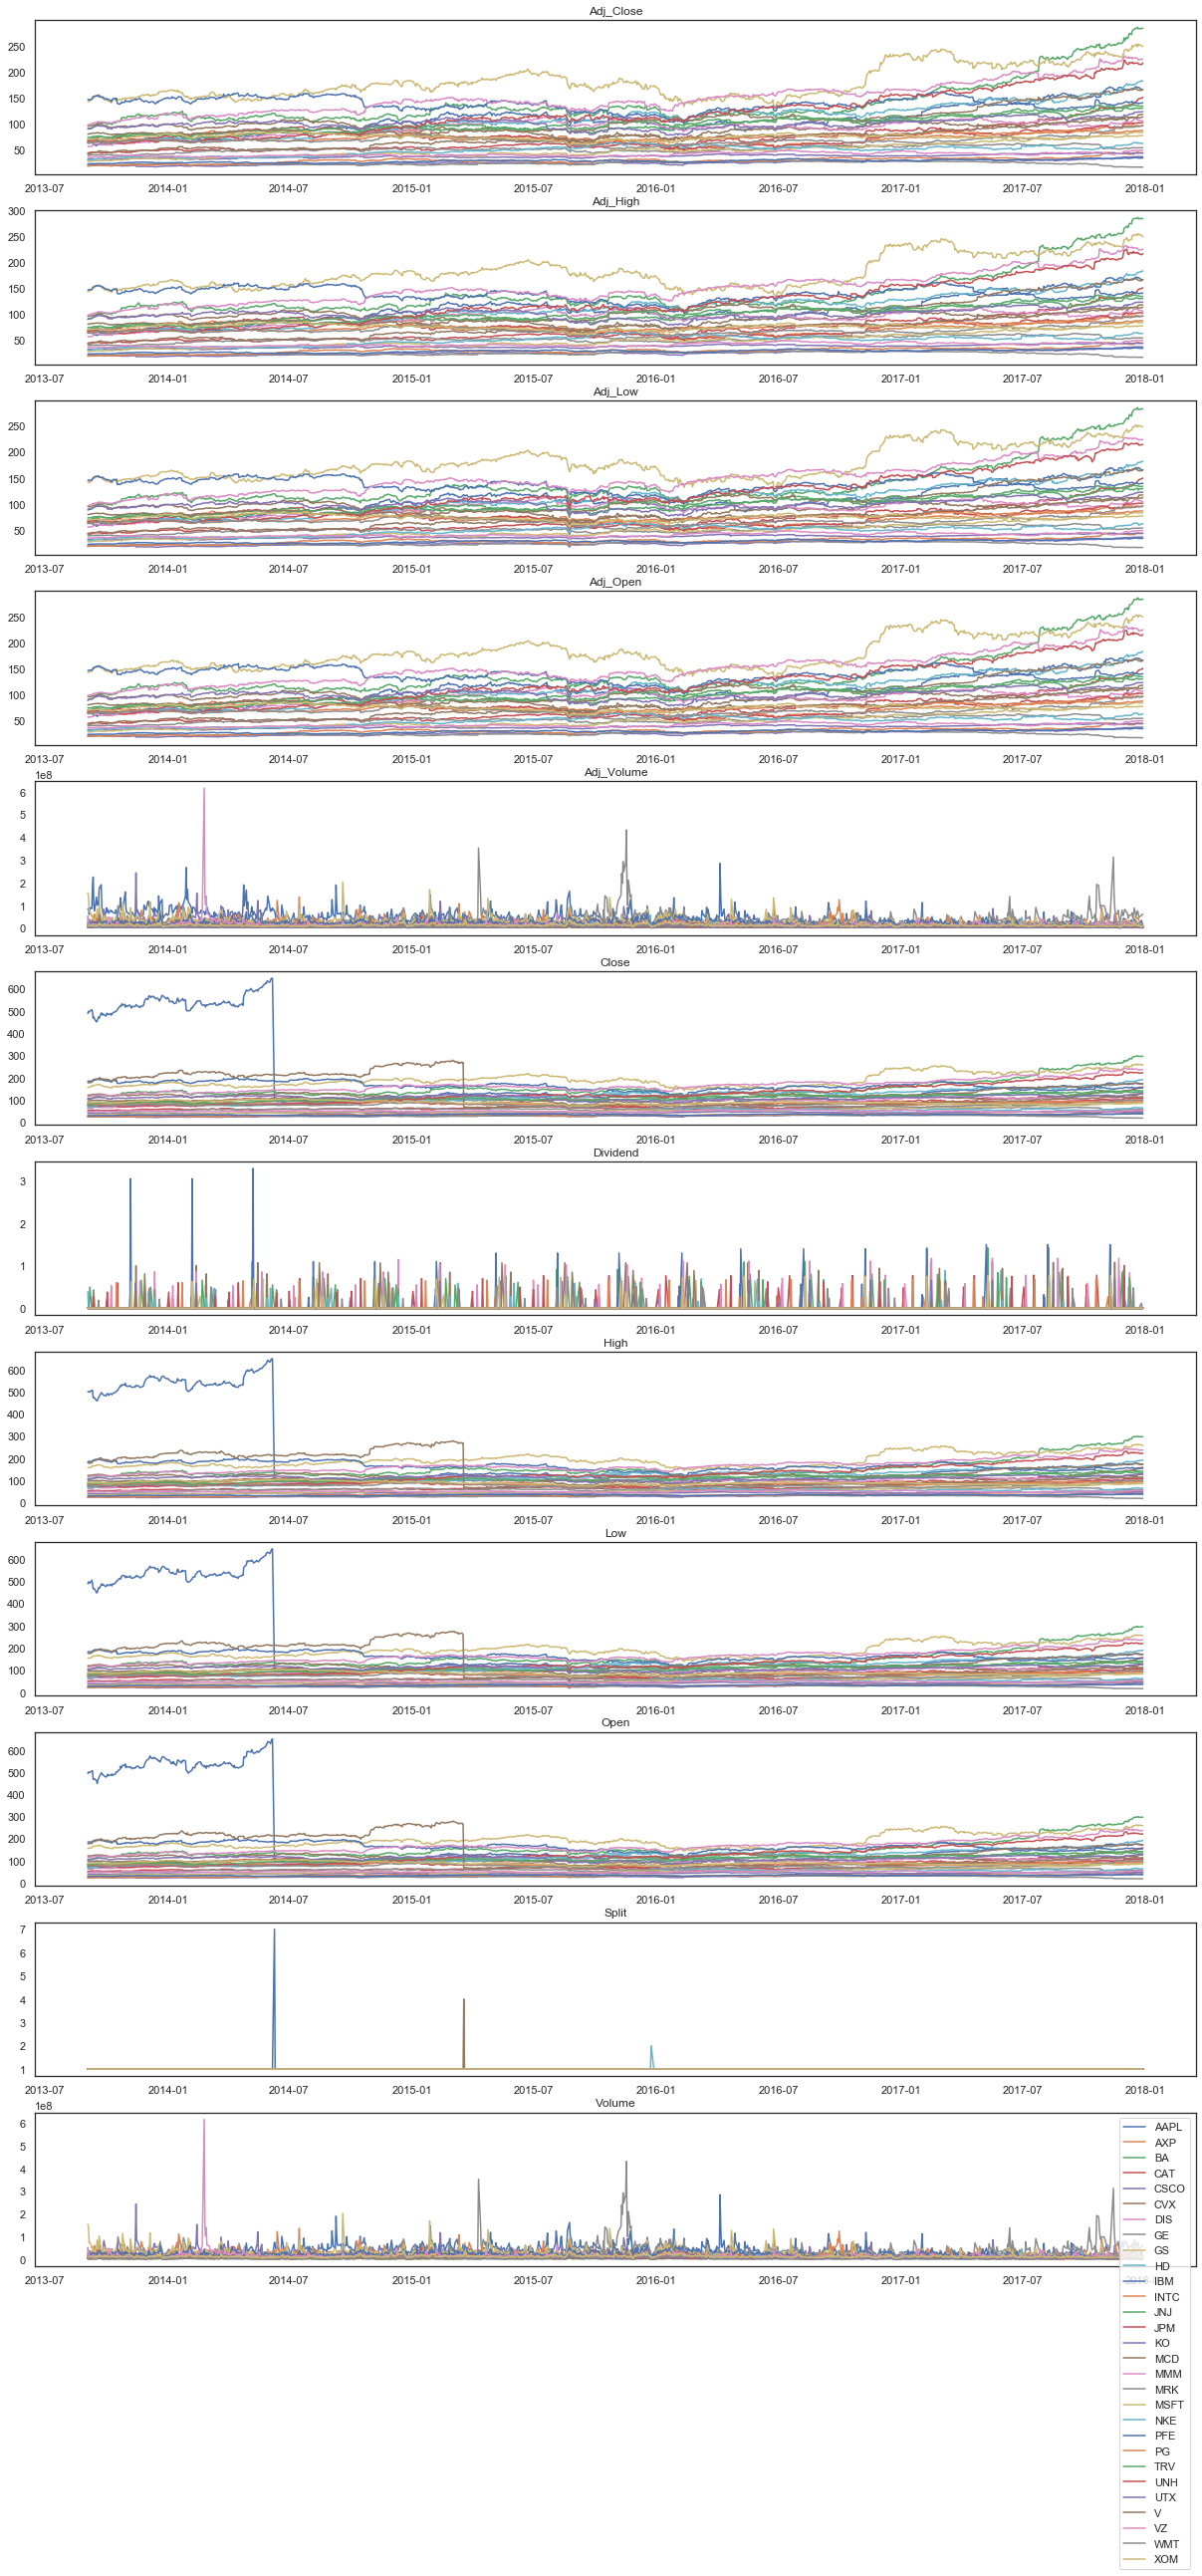

In [13]:
# plot timeseries by company
cols_to_plot = list(set(df.columns) - set(['Ticker', 'Date']))
cols_to_plot.sort()
gs = df.groupby('Ticker')

fig,axs = plt.subplots(nrows=len(cols_to_plot),ncols=1,figsize=(17,32))
plt.tight_layout()

for col,ax in zip(cols_to_plot,axs):
    for n,g in gs:
        x = g['Date']
        y = g[col]
        ax.plot(x,y,label=n)
        ax.set_title(col)
    # print legend once
    if col == cols_to_plot[-1]:
        ax.legend()

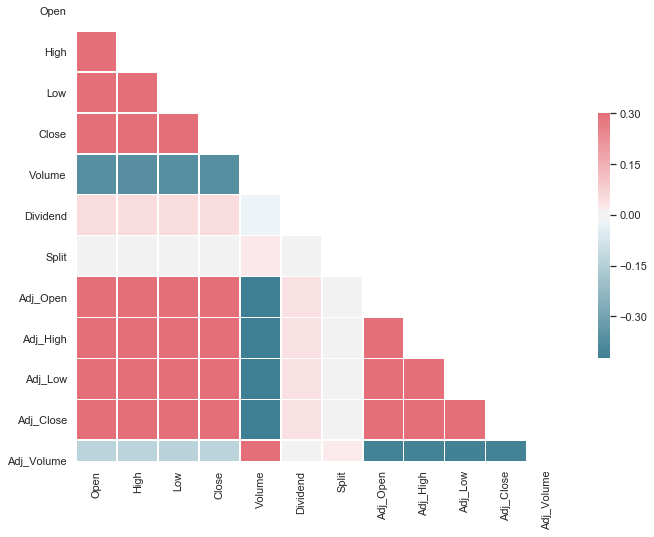

In [14]:
# plot correlation matrix
df_gen = df.drop(columns=['Ticker','Date'])
corr = df_gen.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,vmax=.3, center=0,cmap=cmap, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Methodology

### Data Preprocessing

Preprocessing steps consist of:
* **scaling (standardization)**: whereas stock prices and dividends are of similar nature (currency), volume and split occur at a different unit.
* **windowing**: as the data comes in the form of a time series, it is required to be stored as an time-related array of features.
* **closing price projection**: we extract the adjusted closing price for each window, at 1, 7, 14 and 28 days.
* **split**: train and test datasets are created in a ratio of 70-30.

### Implementation

Here, I fit a RandomForestRegressor to predict a 4-class vector which represent the closing stock price at 1,7,14 and 28 days. Eventually, 4 different models which handle 1-d output might be trained for the scope. Here, GridSearch is not performed yet, as it might lead to a data leak due to the previous scaling. Mean squared error is used to evaluate the model performances on the training and test sets. <br/>
The first run produces a model whose performances show a clear overfitting (MSE on training is about 6 times lower than the MSE on the test set).

### Refinement

To avoid overfitting, I repeat what above, but by building a pipeline object which comprehends a scaler to then perform a grid search to tune the hyper-parameters. Therefore, the windowing is done again, but omitting the scaling.

In [15]:
def preprocess_data(df, window, to_drop=['Date','Ticker'], y_label='Adj_Close', grouper='Ticker'):
    """ Trim data by a given time window, and the associated the adjusted closing price at 1,7,14 and 28 days.
    
    Parameters
    ----------
    df : DataFrame
        data
    
    window : int
        window size (days)
    
    to_drop : array-like
        [optional] column names to drop, default=['Date','Ticker']
    
    y_label : str
        [optional] label to predict, default='Adj_Close'
    
    grouper : string
        [optional] name of the column which represents the company - typically, the ticker, default='Ticker'
    
    Returns
    -------
    X : array
        input tensor for the specificed window. If data is of shape (n,m), X will have shape (n,w,m)
        NOTE: m is the numer of features, but the ones to drop
    
    y : array
        output vector for the adjusted closing price at 1,7,14 and 28 days, of shape=(n,1,4)
    """
    # SCALE
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    # X works on the whole df, minus the non-numeric columns
    scaler_X.fit(df.drop(columns=to_drop,inplace=False))
    # y on a vector shape (4,) (4 times y_label)
    scaler_y.fit(pd.concat([df[y_label]]*4,axis=1))
    
    # WINDOWING
    groups = df.groupby(grouper)
    X = []
    y = []
    
    for n,g in groups:
        # NOTE: we could add a company-related information (e.g. volatility index)
        for i in range(window, len(g)-28):
            g = g.reset_index(drop=True)
            # drop and transform X
            data = scaler_X.transform(g[i-window:i].drop(columns=to_drop,inplace=False))
            # transform y - remember to increase dimensionality of the array
            pred = np.expand_dims(np.array([g.loc[i+1,y_label],g.loc[i+7,y_label],g.loc[i+14,y_label],g.loc[i+28,y_label]]),0)
            pred = scaler_y.transform(pred)
            # done-
            X.append(data)
            y.append(pred)
                 
    return np.array(X),np.array(y),scaler_y

X,y,scaler_y = preprocess_data(df,5)

In [16]:
df.shape, X.shape, y.shape

((31610, 14), (30653, 5, 12), (30653, 1, 4))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, shuffle=False)

mdl = RandomForestRegressor(n_estimators=10)
mdl.fit(X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2])),y_train.reshape(y_train.shape[0],4))

print(mdl)

# predictions
y_train_pred = mdl.predict(X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2])))
y_pred_test = mdl.predict(X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2])))
# performances - scale inverse
mse_train = regression.mean_squared_error(
    scaler_y.inverse_transform(y_train).reshape(y_train.shape[0],4),
    scaler_y.inverse_transform(y_train_pred)
)
mse_test  = regression.mean_squared_error(
    scaler_y.inverse_transform(y_test).reshape(y_test.shape[0],4),
    scaler_y.inverse_transform(y_pred_test)
)

print()
print("TRAIN Mean Squared Error:",mse_train)
print("TEST  Mean Squared Error:",mse_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

TRAIN Mean Squared Error: 2.1575234501710323
TEST  Mean Squared Error: 11.778252694129266


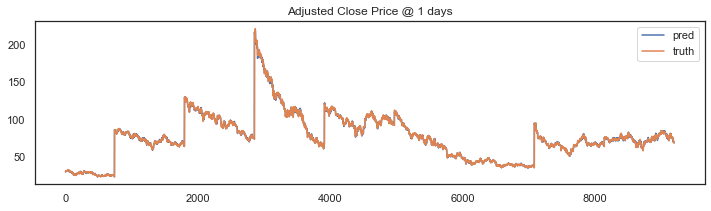

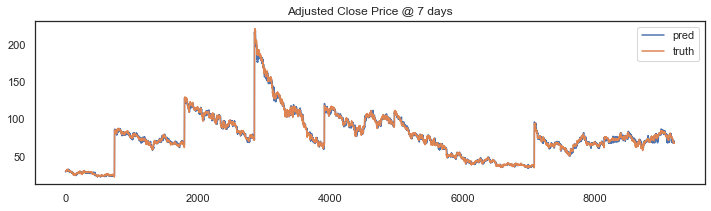

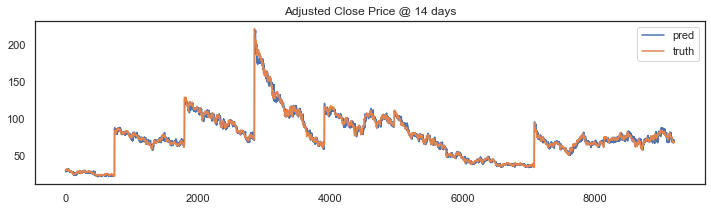

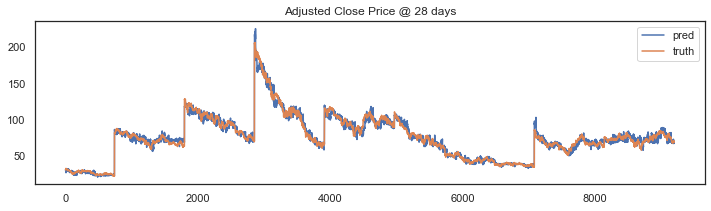

In [18]:
days=[1,7,14,28]

for i in range(len(days)):

    y1=scaler_y.inverse_transform(y_pred_test).T[i]
    y2=scaler_y.inverse_transform(y_test).T[i][0]
    x=np.arange(len(y1))

    fig = plt.figure(figsize=(12,3))
    plt.plot(x,y1,label='pred')
    plt.plot(x,y2,label='truth')
    plt.title('Adjusted Close Price @ {} days'.format(days[i]))
    plt.legend()

#### Refinement

In [29]:
def window_data(df, window, to_drop=['Date','Ticker'], y_label='Adj_Close', grouper='Ticker'):
    """ Trim data by a given time window, and the associated the adjusted closing price at 1,7,14 and 28 days.
    
    Parameters
    ----------
    df : DataFrame
        data
    
    window : int
        window size (days)
    
    to_drop : array-like
        [optional] column names to drop, default=['Date','Ticker']
    
    y_label : str
        [optional] label to predict, default='Adj_Close'
    
    grouper : string
        [optional] name of the column which represents the company - typically, the ticker, default='Ticker'
    
    Returns
    -------
    X : array
        input tensor for the specificed window. If data is of shape (n,m), X will have shape (n,w,m)
        NOTE: m is the numer of features, but the ones to drop
    
    y : array
        output vector for the adjusted closing price at 1,7,14 and 28 days, of shape=(n,1,4)
    """
    # WINDOWING
    groups = df.groupby(grouper)
    X = []
    y = []
    tickers = []
    dates = []
    for n,g in groups:
        # NOTE: we could add a company-related information (e.g. volatility index)
        for i in range(window, len(g)-28):
            g = g.reset_index(drop=True)
            # drop and transform X
            data = g[i-window:i].drop(columns=to_drop,inplace=False)
            # transform y - remember to increase dimensionality of the array
            pred = np.expand_dims(np.array([g.loc[i+1,y_label],g.loc[i+7,y_label],g.loc[i+14,y_label],g.loc[i+28,y_label]]),0)
            # done-
            X.append(data.values)
            y.append(pred)
            tickers.append(n)
            dates.append(g.loc[i]['Date'])
    return np.array(X),np.array(y),np.array(tickers),np.array(dates)

X2,y2,tickers,dates = window_data(df,5)

In [20]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=0.7, random_state=42, shuffle=False)

In [21]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor())
])

params = {
    'reg__n_estimators':[10,15,20],
    'reg__max_depth':[8,10,12],
    'reg__min_samples_leaf':[2,3,4],
    'reg__min_samples_split':[4,5,6]
}

In [22]:
cv = GridSearchCV(pipeline, param_grid=params,cv=5,scoring='r2')
cv.fit(
    X_train2.reshape((X_train2.shape[0],X_train2.shape[1]*X_train2.shape[2])),y_train2.reshape(y_train2.shape[0],4)
)

mdl2 = cv.best_estimator_
print(mdl2)

y_pred_train2 = mdl2.predict(
    X_train2.reshape((X_train2.shape[0],X_train2.shape[1]*X_train2.shape[2]))
)
y_pred_test2 = mdl2.predict(
    X_test2.reshape((X_test2.shape[0],X_test2.shape[1]*X_test2.shape[2]))
)

mse_train2 = regression.mean_squared_error(y_train2.reshape(y_train2.shape[0],4),y_pred_train2)
mse_test2  = regression.mean_squared_error(y_test2.reshape(y_test2.shape[0],4),y_pred_test2)

print("TRAIN Mean Squared Error:",mse_train2)
print("TEST  Mean Squared Error:",mse_test2)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=8, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=3, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=20, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)
TRAIN Mean Squared Error: 10.277112249234694
TEST  Mean Squared Error: 9.605166328608647


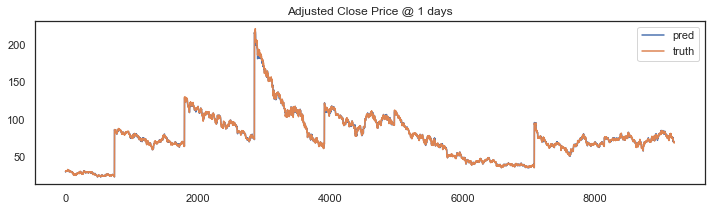

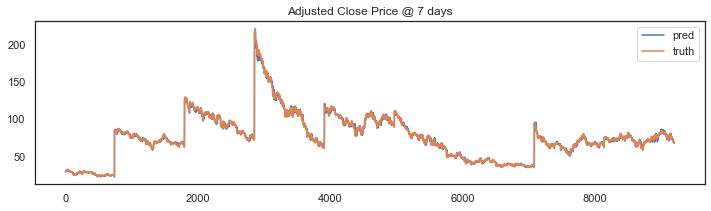

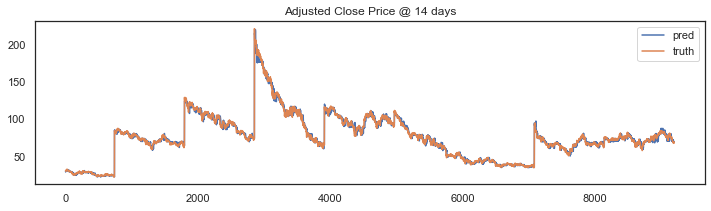

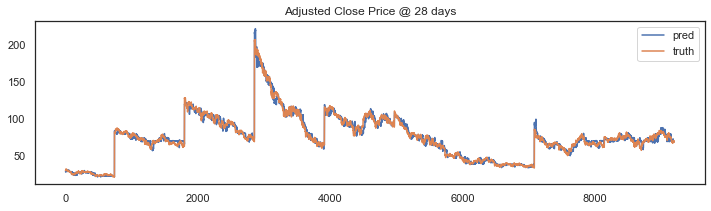

In [28]:
days=[1,7,14,28]

for i in range(len(days)):
    y_1=y_pred_test2.T[i]
    y_2=y_test2.T[i][0]
    x=np.arange(len(y1))

    fig = plt.figure(figsize=(12,3))
    plt.plot(x,y_1,label='pred')
    plt.plot(x,y_2,label='truth')
    plt.title('Adjusted Close Price @ {} days'.format(days[i]))
    plt.legend()

In [ ]:
# with open(os.path.join(data_folder,"pipeline.p"),'wb') as f:
#     pickle.dump(mdl2,f)

## Results

### Model Evaluation and Validation

The model is evaluated against its ability to predict returns. The returns at 1,7,14 and 28 days are calculated for the truth and the predicted prices. Then, their difference is analysed in order to show the error. More specifically:
* The mean of the difference shows if our model has the tendendcy to produce pessimistic/optimistic prices in the case of a predominant negative or positive error.
* The standard deviation of the difference shows how confident we can be about the model's outcome. It appears that the model requires outstanding improvements before being taken seriously, as we discuss the results below.


In [25]:
y2_pred = mdl2.predict(X2.reshape(X2.shape[0],X2.shape[1]*X2.shape[2]))

In [26]:
# Open, High, Low, Close, Volume, Dividend, Split, Adj_Open, Adj_High, Adj_Low, Adj_Close, Adj_Volume
RoR = {}

for i,(d,t) in enumerate(zip(dates,tickers)):
    if not t in RoR.keys():
        RoR[t] = []
    ror = ((X2[i][0][10]-X2[i][0][7])/X2[i][0][7])*100
    RoR[t].append(ror)

In [30]:
truth = {}
pred  = {}
diff  = {}
tcks  = {'Ticker':tickers}
dts   = {'Date':dates}

for i in range(4):
    t = 100*(y2[:,0,i]-X2[:,4,7])/X2[:,4,7]
    p = 100*(y2_pred[:,i]-X2[:,4,7])/X2[:,4,7]
    d = p - t
    truth[i] = t
    pred[i]  = p
    diff[i]  = d

#### DataFrame for Returns

Here, we store the returns into a dataframe, reporing truth, predicted and differnce (error) values.

In [31]:
# result dataframe
df_results = pd.concat([pd.DataFrame(truth,),#columns=['Tr_1day','Tr_7d','Tr_14d','Tr_28d']
                        pd.DataFrame(pred, ),#columns=['Pr_1day','Pr_7d','Pr_14d','Pr_28d']
                        pd.DataFrame(diff, ),#columns=['Er_1day','Er_7d','Er_14d','Er_28d']
                        pd.DataFrame(tcks),pd.DataFrame(dts)],axis=1)
df_results.head()

,0,1,2,3,0,1,2,3,0,1,2,3,Ticker,Date
0,0.212436,-0.861228,-1.332032,0.618887,-0.867180,-2.409766,-4.013737,-5.496705,-1.079616,-1.548538,-2.681705,-6.115592,AAPL,2017-12-20
1,0.886373,-3.145194,-3.082290,0.421240,-1.265568,-2.893151,-4.595576,-6.285829,-2.151941,0.252042,-1.513287,-6.707069,AAPL,2017-12-19
2,-0.605610,-3.262298,-1.119808,-0.484625,-1.369136,-3.134227,-5.186942,-7.545997,-0.763525,0.128070,-4.067134,-7.061372,AAPL,2017-12-18
3,-1.521043,-3.356587,-0.451738,-0.718336,-0.177289,-1.410942,-2.471823,-3.046407,1.343754,1.945645,-2.020085,-2.328070,AAPL,2017-12-15
4,-0.783275,-2.297990,0.771756,-1.007854,-1.121775,-3.654035,-5.172150,-7.626010,-0.338501,-1.356045,-5.943906,-6.618155,AAPL,2017-12-14


In [32]:
df_results.describe()

,0,1,2,3,0,1,2,3,0,1,2,3
count,30653.000000,30653.000000,30653.000000,30653.000000,30653.000000,30653.000000,30653.000000,30653.000000,30653.000000,30653.000000,30653.000000,30653.000000
mean,-0.064943,-0.349022,-0.660375,-1.253191,-0.082780,-0.425794,-0.775756,-1.403564,-0.017836,-0.076771,-0.115381,-0.150373
std,1.390063,3.087831,4.229838,5.919779,0.831289,1.221156,1.757328,2.749164,1.508920,2.921509,3.857334,5.173643
min,-10.403576,-15.705247,-18.640535,-27.767035,-5.185234,-10.367544,-12.581384,-18.889328,-12.396558,-17.498349,-20.582296,-30.434620
25%,-0.749415,-2.114191,-3.228079,-5.100384,-0.601290,-1.109176,-1.722369,-2.804624,-0.859300,-1.759468,-2.452129,-3.362177
50%,-0.082707,-0.439099,-0.825059,-1.607244,-0.128373,-0.527835,-0.953412,-1.631154,-0.059714,-0.095194,-0.086020,-0.072869
75%,0.583501,1.263256,1.706667,2.224064,0.380698,0.197496,0.049955,-0.335393,0.783213,1.660509,2.286726,3.262348
max,18.741436,21.471487,29.706575,40.148487,13.106667,15.751705,18.357335,30.530237,11.160828,16.223839,16.258441,26.749059


### Justification

Here, the final results are discussed in detail. We focus on the difference between predicted and true returns. As previously stated, we look at its mean to evaluate if our model has the tendendcy to produce pessimistic/optimistic prices in the case of a predominant negative or positive error. Its standard deviation helps us in calculating the confidence interval of the produced prediction.

Mean and 95% confidence intervals are plotted below. The error at 1 day shows how the return might be wrong by a nominal -3/+3%. This is quite a lot, so to have an useful guess, we should look for a predicted outcome >3% (albeit further considerations are required). This makes the model being hardly useful as increments >3% in one day refers to quite specific events. A behavioural approach to investment might be considered in such case, however, the model could help in supporting that.

Then, the confidence intervals at 7, 14 and 28 days increase steadily by a further 30% for each days, making the model quite uneffective. We want also to plot a few examples about the returns, to see if it is possible to notice any patterns.

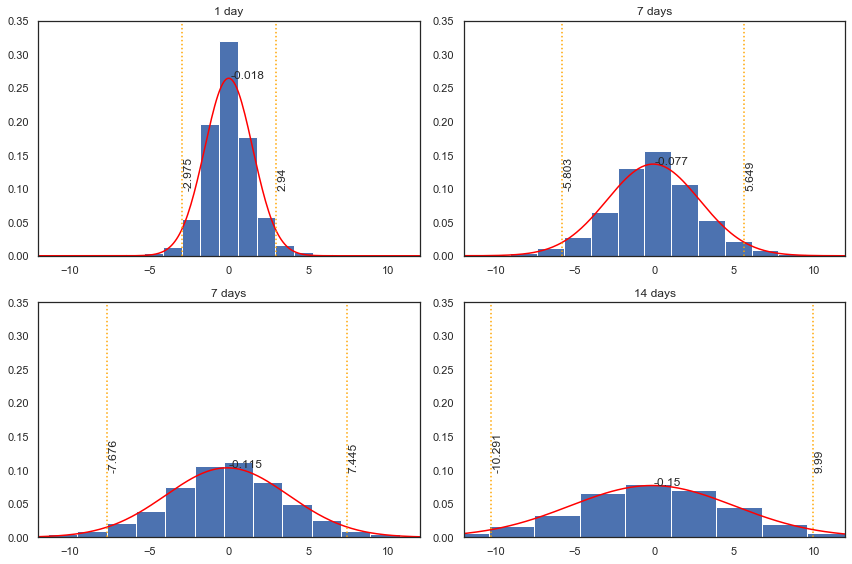

In [33]:
dds = ['1 day','7 days', '14 days', '28 days']
fig, axs = plt.subplots(2,2,figsize=(12,8))
x = np.arange(-20,20,0.1)
for i in range(len(axs)):
    for j in range(len(axs[i])):
        axs[i,j].hist(df_results.iloc[:,8+i*2+j],bins=20, label=dds[i*2+j],density=True)
        mean = df_results.iloc[:,8+i*2+j].mean()
        std  = df_results.iloc[:,8+i*2+j].std()
        y    = stats.norm.pdf(x,mean,std)
        axs[i,j].plot(x,y,color='red')
        axs[i,j].text(mean+0.1,y.max(),round(mean,3),)
        z1 = stats.norm(mean,std).ppf(0.025)
        z2 = stats.norm(mean,std).ppf(1-0.025)
        axs[i,j].axvline(z1, ls=':', color='orange', label=z1)
        axs[i,j].text(z1+0.1,.1,round(z1,3),rotation=90)
        axs[i,j].axvline(z2, ls=':', color='orange', label=z2)
        axs[i,j].text(z2+0.1,.1,round(z2,3),rotation=90)
        axs[i,j].set_xlim((-12,12))
        axs[i,j].set_ylim((0,0.35))
        axs[i,j].set_title(dds[i+j])
        
plt.tight_layout()


Here, returns are plotted for 3 companies. The model produces much stable outputs compared to the real returns.

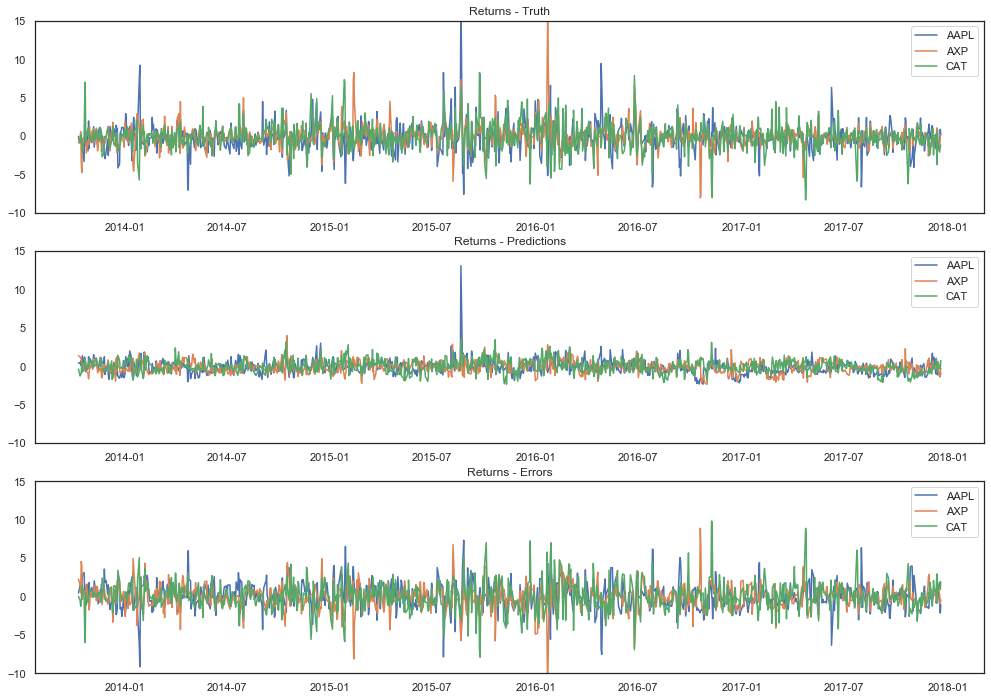

In [34]:
fig,axs = plt.subplots(3,1,figsize=(17,12))

def show_returns(to_show, shift=0):
    """Show returns for a set of companies at 1,7,14 or 28 days.
    
    Parameters
    ----------
    to_show : array-like
        contains the tickers
        
    shift : int
        0 = 1 day
        1 = 7 days
        2 = 14 days
        3 = 28 days
    """
    gs = df_results.groupby('Ticker')

    for n,g in gs:
        if n in to_show:
            x = g['Date'].values
            y1 = g.iloc[:,shift+0].values
            y2 = g.iloc[:,shift+4].values
            y3 = g.iloc[:,shift+8].values
            axs[0].plot(x,y1,label=n)
            axs[1].plot(x,y2,label=n)
            axs[2].plot(x,y3,label=n)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    axs[0].set_ylim((-10,15))
    axs[1].set_ylim((-10,15))    
    axs[2].set_ylim((-10,15))
    axs[0].set_title('Returns - Truth')
    axs[1].set_title('Returns - Predictions')
    axs[2].set_title('Returns - Errors')
    
# df_results['Ticker'].unique()
show_returns(['AAPL','AXP','CAT'],0)

## Conclusion

### Reflection

The end-to-end product of this project tries to bring together historical data about some of the S&P500 companies, where available through Quandl API. The data did not present inconsistencies, nor missing values, requiring only standard scaling practice before proceeding through picking a model to train and test. 

The selection fell on scikit-learn's random forest regressor. An initial overfitting happened due to lack of tuning hyper parameters, corrected by performing a grid search, and training the model through cross-validation (this was possible by creating a pipeline in order to avoid data leaks on cross validation).

Results were tested against analysing rate on returns, or RoR, and so by comparing the predicted with true returns. By doing so, it was possible to define a confidence interval relative to each time range. 7-days returns shows a 95% confidence interval of about -/+5% which was within the project's guidelines, however, by far a result to be considered good in  real-world business scenario.

Developing knowledge of time series as well as of investment principles and returns calculation was one of the most interesting aspect of the project. 

### Improvement

The nature of the problem, as well as the data here digested presents a high degree of non-linearity. Improvements to the system can be made by choosing a different model (e.g. SVM regressor to be trained on each time range) which is more prone to capture highly non-linear patterns. Eventually, going for a deep neural network might help: nlp-oriented techniques such as RNN or LSTM might be used to also include the temporality of the data (here, the window is digested as a flat vector by the model).

Then, futher feature engineering might be required. For instance, returns might be included. Moreover, company-specific indices might help in determining the volatility of the company, or their financial status such as quaterly reports data.

Finally, test of the window size might be run in order to see how this affect our model. However, to avoid increasing the dimensionality of data too much without providing a time-related approach to train our model (such in the case of a LSTM), might produce worse rather than better results.